# Import Modules

In [1]:
import base64
import os
import zipfile
import io
import shutil
import pandas as pd
import geopandas as gpd
from shapely import wkt, wkb
from geoalchemy2 import Geometry, WKTElement


PATH_FILES = "/mnt/c/Users/Pooya/Desktop/VoronoiDiagram/"

# Read Data

In [7]:
aquifers = gpd.read_file(f"{PATH_FILES}/Isfahan/Aquifer/Aquifer.shp")
piezometer = gpd.read_file(f"{PATH_FILES}/Isfahan/Piezometer/Piezometer.shp")

func = lambda geom: wkb.loads(wkb.dumps(geom, output_dimension=2))
aquifers['geometry'] = aquifers['geometry'].apply(func)
piezometer['geometry'] = piezometer['geometry'].apply(func)

aquifers = aquifers.to_crs(epsg=32639)
piezometer = piezometer.to_crs(epsg=32639)

data = pd.read_excel(io=f"{PATH_FILES}/Isfahan/DataDay15.xlsx", sheet_name="Data")
geoinfo = pd.read_excel(io=f"{PATH_FILES}/Isfahan/DataDay15.xlsx", sheet_name="GeoInfo")

# Define Class Voronoi Diagram

In [ ]:
from shapely.ops import voronoi_diagram


from shapely.geometry import Polygon, MultiPolygon
from shapely.wkt import loads as load_wkt


class VoronoiDiagrams:
    
    def __init__(self):
        pass
        
    
    def create_thiessen_polygons(self, points, limit):
        
        # RESET THE INDEX OF POINTS GEODATAFRAME
        points.reset_index(drop=True)
        
        # CONVERT points TO MultiPoint
        multipoints = points.unary_union
        
        # CREATE PRIMARY VORONOI DIAGRAM
        pvd = voronoi_diagram(
            geom=multipoints,
        )
        
        # CONVERT TO GeoSeries AND explode TO SINGLE POLYGONS
        pvd = gpd.GeoSeries([pvd]).explode(index_parts=True)
        
        # CONVERT TO GEODATAFRAME
        gdf_pvd = gpd.geodataframe.GeoDataFrame(
            geometry=pvd,
            crs=points.crs
        )
        
        # RESET THE INDEX OF PRIMARY VORONOI DIAGRAM GEODATAFRAME
        gdf_pvd.reset_index(drop=True)
        
        # CLIP PRIMARY VORONOI DIAGRAM TO THE MASK EXTEND.
        gdf_vd = gpd.clip(
            gdf=gdf_pvd,
            mask=limit
        )	
        
        # SPATIAL JOIN BY INTERSECTING AND DISSOLVE BY `index_right`
        gdf_vd = (gpd.sjoin(left_df=gdf_vd, right_df=points, how='inner', predicate='intersects').dissolve(by='index_right').reset_index(drop=True))

        # CALCULATE AREA OF EACH POLYGON
        gdf_vd["AREA_THIESSEN_POLYGON"] = gdf_vd.geometry.area / 1000 / 1000
        
        # CALCULATE AREA OF LIMIT        
        gdf_vd["AREA_LIMIT_POLYGON"] = [limit.geometry.area[0] / 1000 / 1000] * len(points)

        return gdf_vd
    

/home/pooya/w/dashboard/.venv/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


                                             geometry  ID  \
0   MULTIPOLYGON (((582171.967 3560472.355, 582171...   1   
1   POLYGON ((604256.788 3571778.943, 605922.604 3...   2   
2   POLYGON ((642848.587 3570487.795, 643091.148 3...   3   
3   POLYGON ((624590.508 3580798.587, 624135.161 3...   4   
4   MULTIPOLYGON (((599838.042 3577527.959, 600177...   5   
5   POLYGON ((587714.456 3563728.172, 590432.171 3...   6   
6   POLYGON ((643319.640 3571404.699, 665339.670 3...   7   
7   POLYGON ((644298.462 3576397.724, 644922.948 3...   8   
8   POLYGON ((591119.564 3565892.208, 594593.845 3...   9   
9   POLYGON ((583523.587 3558015.795, 583584.567 3...  10   
10  POLYGON ((583373.880 3569010.059, 582674.346 3...  11   
11  POLYGON ((615815.444 3570619.885, 616084.846 3...  12   
12  POLYGON ((598791.080 3564382.141, 598966.721 3...  13   
13  MULTIPOLYGON (((628855.982 3566873.149, 628896...  14   
14  POLYGON ((644298.462 3576397.724, 643757.871 3...  15   
15  POLYGON ((586849.037

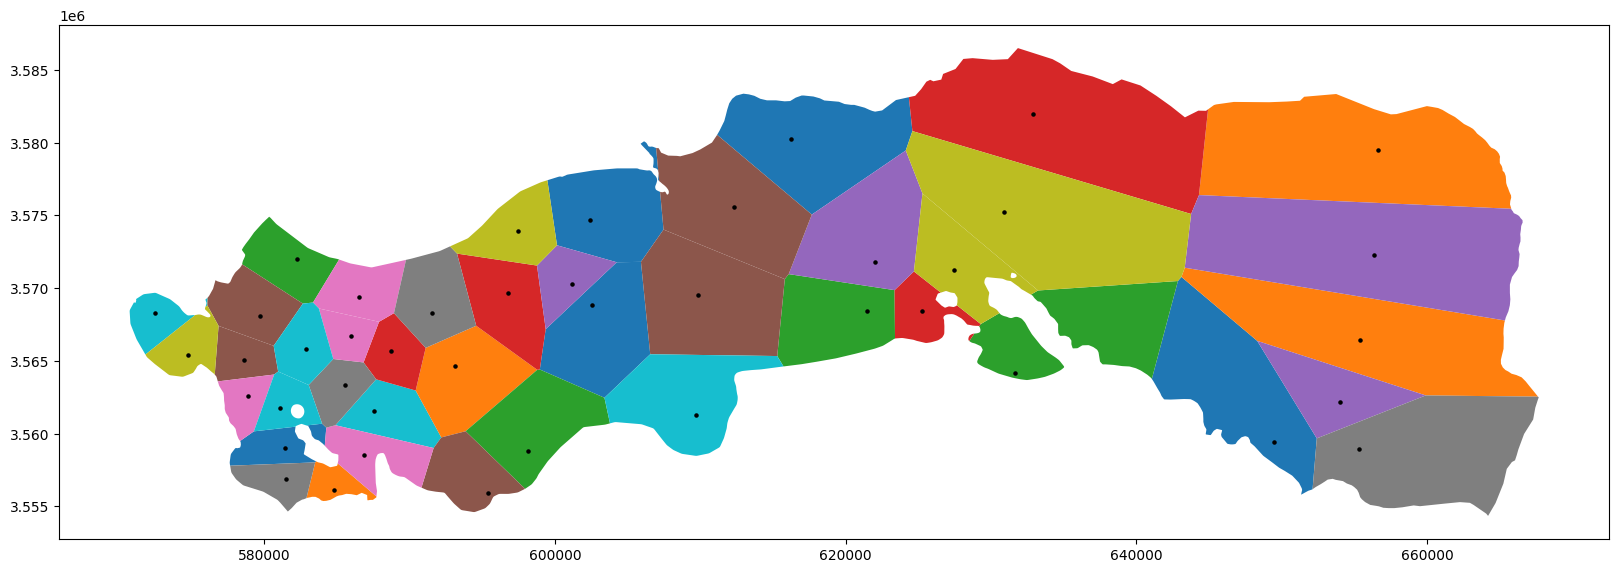

In [16]:
from shapely.ops import voronoi_diagram

points = piezometer.copy()
limit = aquifers.copy()


points.reset_index(drop=True)
multipoints = points.unary_union
pvd = voronoi_diagram(
    geom=multipoints,
)
pvd = gpd.GeoSeries([pvd]).explode(index_parts=True)
gdf_pvd = gpd.geodataframe.GeoDataFrame(
    geometry=pvd,
    crs=points.crs
)
gdf_pvd.reset_index(drop=True)
gdf_vd = gpd.clip(
    gdf=gdf_pvd,
    mask=limit
)
gdf_vd = (gpd.sjoin(left_df=gdf_vd, right_df=points, how='inner', predicate='intersects').dissolve(by='index_right').reset_index(drop=True))
gdf_vd["AREA_THIESSEN_POLYGON"] = gdf_vd.geometry.area / 1000 / 1000
gdf_vd["AREA_LIMIT_POLYGON"] = [limit.geometry.area[0] / 1000 / 1000] * len(points)


base = gdf_vd.plot(figsize=(20, 20), column="LOCATION")
points.plot(ax=base, marker='o', color='black', markersize=5)

print(gdf_vd)